<a href="https://colab.research.google.com/github/alfie1104/deeplearning-with-pytorch/blob/main/6_basic_cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# convert MNIST Image files into a Tensor of 4-Dimensions(# of images, height, width, color channel)
transform = transforms.ToTensor()

In [3]:
# Train Data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16299010.37it/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 482771.97it/s]


Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4444877.38it/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1383681.64it/s]

Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [4]:
# Test Data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# Create a small batch size for images... let's say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
# Define CNN model
# Describe convolutional layer and what it's doing (2 convolutional layers)
# This is just an example in the next video we'll build out the actual model
conv1 = nn.Conv2d(1, 6, 3,1) # input, output, kernel, stride
conv2 = nn.Conv2d(6, 16, 3,1)

In [9]:
# Grab 1 MNIST record/image
for i, (X_Train, y_train) in enumerate(train_data):
  break

In [10]:
X_Train.shape # torch.Size([1, 28, 28]) -> the size of MNIST data is 28 x 28 pixels

torch.Size([1, 28, 28])

In [11]:
x = X_Train.view(1,1,28,28)

In [12]:
# Perform our first convolution
x = F.relu(conv1(x)) # Rectified Linear Unit for our activation function

In [13]:
x.shape # torch.Size([1, 6, 26, 26]) -> 1 single image, 6 is the filters we asked for, 26 x 26 (original MNIST data is 28x28. because we didn't set any padding at convolutional layer, it is shirinked to 26x26)

torch.Size([1, 6, 26, 26])

In [14]:
# pass thru the pooling layer
x = F.max_pool2d(x, 2, 2) # kernel of 2 and stride of 2

In [15]:
x.shape # torch.Size([1, 6, 13, 13]) -> 1 single image, 6 is the filters we asked for, 13 x 13 from 26/2 x 26/2

torch.Size([1, 6, 13, 13])

In [16]:
# Do our second convolutional layer
x = F.relu(conv2(x))

In [17]:
x.shape # torch.Size([1, 16, 11, 11]) -> 1 single image, 16 filters we defined, 11 x 11 is shirinked from 13 x 13 (we didnt't set padding, so we lose 2 pixels around the outside of the image)

torch.Size([1, 16, 11, 11])

In [18]:
# Pooling layers
x = F.max_pool2d(x, 2, 2)

In [19]:
x.shape # torch.Size([1, 16, 5, 5]) -> -> 11/2 = 5.5 but we have to round down because we can't invent data to round up

torch.Size([1, 16, 5, 5])

In [20]:
# ((28[original]-2[first padding]) / 2[first pooling] - 2[second padding])/ 2[second pooling]
((28-2)/2-2)/2

5.5

In [21]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*16, 120) # 5x5 pixels * 16 outputs from conv2 laye, 120 is chosen arbitrarily
    self.fc2 = nn.Linear(120, 84) # 120 and 84 are arbitrarily chosen
    self.fc3 = nn.Linear(84, 10) # 10 numbers (0 ~ 9)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2) # 2 : 2 x 2 kernel,  2 : stride 2
    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2) # 2 : 2 x 2 kernel,  2 : stride 2

    # Re-View to flatten it out
    X = X.view(-1, 16*5*5) # negative one so that we can vary the batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)


In [22]:
# Create an instance of our Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Smaller the Learning Rate, longer its gonna take to train.

In [25]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []


# For Loop of Epochs
for i in range(epochs):
  train_corr = 0
  test_corr = 0

  # Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b += 1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False = 0,
    train_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out some results
    if b % 600 == 0:
      print(f'Epoch : {i} Batch : {b} Loss : {loss.item()}')

  train_losses.append(loss)
  train_correct.append(train_corr)

  # Test
  with torch.no_grad(): # No gradient so we don't update our weights and biases with test data
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      test_corr += (predicted == y_test).sum() # T=1 F=0 and sum away

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(test_corr)


current_time = time.time()
total = current_time - start_time
print(f'Training Took : {total/60} minutes')

Epoch : 0 Batch : 600 Loss : 0.012505742721259594
Epoch : 0 Batch : 1200 Loss : 0.059554439038038254
Epoch : 0 Batch : 1800 Loss : 0.01286345161497593
Epoch : 0 Batch : 2400 Loss : 0.13558034598827362
Epoch : 0 Batch : 3000 Loss : 0.004820442292839289
Epoch : 0 Batch : 3600 Loss : 0.010546308942139149
Epoch : 0 Batch : 4200 Loss : 0.24395230412483215
Epoch : 0 Batch : 4800 Loss : 0.007479517254978418
Epoch : 0 Batch : 5400 Loss : 0.009367642924189568
Epoch : 0 Batch : 6000 Loss : 0.0018434313824400306
Epoch : 1 Batch : 600 Loss : 0.03221464157104492
Epoch : 1 Batch : 1200 Loss : 0.003333463566377759
Epoch : 1 Batch : 1800 Loss : 0.04126342386007309
Epoch : 1 Batch : 2400 Loss : 0.14685525000095367
Epoch : 1 Batch : 3000 Loss : 0.12026345729827881
Epoch : 1 Batch : 3600 Loss : 0.0001952919119503349
Epoch : 1 Batch : 4200 Loss : 0.00016604487609583884
Epoch : 1 Batch : 4800 Loss : 0.0006250619189813733
Epoch : 1 Batch : 5400 Loss : 0.0019755663815885782
Epoch : 1 Batch : 6000 Loss : 0.00

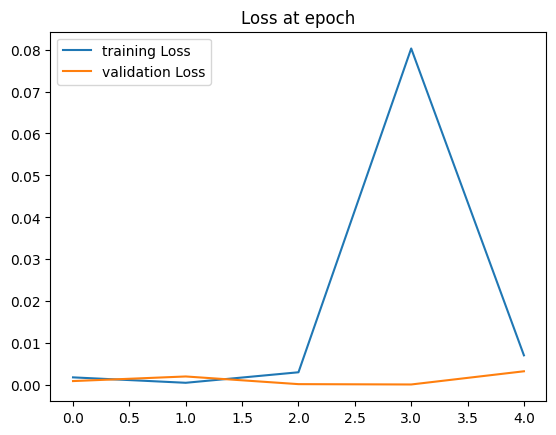

In [26]:
# Graph the  loss at epoch
train_losses = [tl.item() for tl in train_losses]

plt.plot(train_losses, label="training Loss")
plt.plot(test_losses, label="validation Loss")
plt.title("Loss at epoch")
plt.legend()

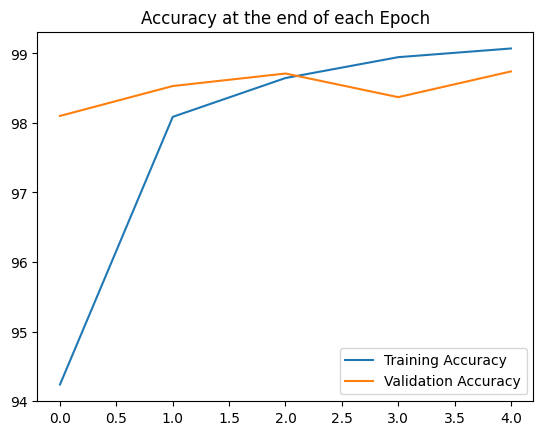

In [27]:
# Graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [31]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [32]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [35]:
# Did for correct
correct.item()/len(test_data)*100

98.74000000000001

In [39]:
# Grab an image
test_data[4143] # Tensor with an image in it... at end, it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [40]:
# Grab just the data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [41]:
# Reshape it
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

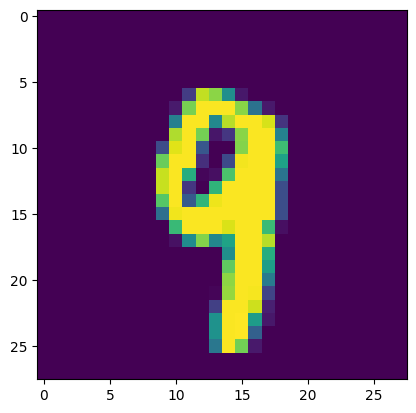

In [42]:
# show the image
plt.imshow(test_data[4143][0].reshape(28,28))

In [43]:
# Pass the image thru our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28x28 image

In [44]:
# Check the new prediction... get probabilities
new_prediction

tensor([[-1.7871e+01, -1.6704e+01, -1.9303e+01, -1.3646e+01, -9.1631e+00,
         -1.6256e+01, -2.5329e+01, -1.2956e+01, -1.0458e+01, -1.3732e-04]])

In [45]:
new_prediction.argmax()

tensor(9)